In [1]:
%matplotlib notebook

# Learning a simple non-linear, noisy function... with convolutions!

Using our standard dataset.

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

N = 1000 # observations|
P = 10000 # samples
epochs = 100
batch_size = 100

domain = np.linspace(0, 2.*np.pi, P)
Y = np.sin(domain)
amin = np.amin(Y)
amax = np.amax(Y)
Y = (Y - amin) / (amax - amin) 
X = np.array([Y + np.random.normal(size=P, scale=0.1) for _ in range(N)])

plt.figure()

for x in X[0:10, :]:
    plt.scatter(domain, x, color='b', alpha=0.1, s=1)
plt.scatter(domain, Y, color='r', s=1)
plt.show()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<Figure size 640x480 with 1 Axes>

## Specify Model

In [6]:
graph = tf.get_default_graph()
with graph.as_default():
        
    dataset = tf.data.Dataset.from_tensor_slices(X)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    
    iterator = dataset.make_initializable_iterator()
    data = iterator.get_next()
    
    # encoder
    x = tf.reshape(data, [batch_size, P, 1])
        
    print('Encoder conv layer shapes:')
    print(x.get_shape().as_list())
    x = tf.layers.conv1d(x, 64, 3, strides=3, padding='SAME')
    x = tf.nn.elu(x)
    print(x.get_shape().as_list())
    x = tf.layers.conv1d(x, 32, 3, strides=3, padding='SAME')
    x = tf.nn.elu(x)
    print(x.get_shape().as_list())
    x = tf.layers.conv1d(x, 16, 3, strides=3, padding='VALID')
    x = tf.nn.elu(x)
    print(x.get_shape().as_list())

    # drop channel dimension
    x = tf.reshape(x, [batch_size, -1])
    
    latent_code = tf.layers.dense(x, 16, activation=None)

    # decoder
    x = tf.layers.dense(latent_code, 370)
        
    print('Decoder conv layer shapes:')
    print(x.get_shape().as_list())
    x = tf.reshape(x, [batch_size, 1, 370, 1])
    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=(1, 3),
        strides=(1, 3), padding='SAME')
    x = tf.nn.elu(x)
    x = tf.squeeze(x, [1])
    padding = tf.constant([[0, 0], [1, 0], [0, 0]])
    x = tf.pad(x, padding)
    print(x.get_shape().as_list())


    x = tf.expand_dims(x, axis=1)
    x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=(1, 3),
        strides=(1, 3), padding='SAME')
    x = tf.nn.elu(x)
    x = tf.squeeze(x, [1])
    print(x.get_shape().as_list())
    
    x = tf.expand_dims(x, axis=1)
    x = tf.layers.conv2d_transpose(x, filters=1, kernel_size=(1, 3),
        strides=(1, 3), padding='SAME')
    x = tf.nn.elu(x)
    x = tf.squeeze(x, [1])
    x = tf.pad(x, padding)
    print(x.get_shape().as_list())

    x_hat = tf.reshape(x, [batch_size, -1])
    
    loss = tf.losses.mean_squared_error(data, x_hat)
    
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss=loss)

Encoder conv layer shapes:
[100, 10000, 1]
[100, 3334, 64]
[100, 1112, 32]
[100, 370, 16]
Decoder conv layer shapes:
[100, 370]
[100, 1111, 32]
[100, 3333, 64]
[100, 10000, 1]


## Train

In [7]:
loss_log = list()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(epochs):
        print('Running epoch {}'.format(epoch))
        sess.run(iterator.initializer)
        sess.run(train_op)
        loss_log.append(sess.run(loss))

    x_hat = sess.run(x_hat)

Running epoch 0
Running epoch 1
Running epoch 2
Running epoch 3
Running epoch 4
Running epoch 5
Running epoch 6
Running epoch 7
Running epoch 8
Running epoch 9
Running epoch 10
Running epoch 11
Running epoch 12
Running epoch 13
Running epoch 14
Running epoch 15
Running epoch 16
Running epoch 17
Running epoch 18
Running epoch 19
Running epoch 20
Running epoch 21
Running epoch 22
Running epoch 23
Running epoch 24
Running epoch 25
Running epoch 26
Running epoch 27
Running epoch 28
Running epoch 29
Running epoch 30
Running epoch 31
Running epoch 32
Running epoch 33
Running epoch 34
Running epoch 35
Running epoch 36
Running epoch 37
Running epoch 38
Running epoch 39
Running epoch 40
Running epoch 41
Running epoch 42
Running epoch 43
Running epoch 44
Running epoch 45
Running epoch 46
Running epoch 47
Running epoch 48
Running epoch 49
Running epoch 50
Running epoch 51
Running epoch 52
Running epoch 53
Running epoch 54
Running epoch 55
Running epoch 56
Running epoch 57
Running epoch 58
Running

## Metrics

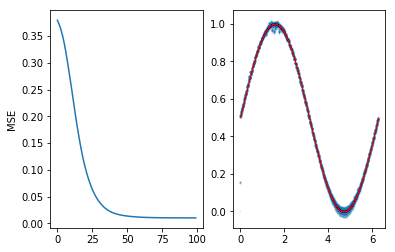

In [10]:
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(loss_log)
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.scatter(domain, np.mean(x_hat, axis=0), alpha=0.1, s=1)
# plt.scatter(domain, x_hat[0,], alpha=0.1, s=1)
plt.scatter(domain, Y, color='r', s=0.001)

plt.show()